In [ ]:
from tkinter import *
import tkinter
from tkinter import filedialog
import numpy as np
from tkinter.filedialog import askopenfilename
import pandas as pd 
from tkinter import simpledialog
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras.layers
from tensorflow.keras.models import model_from_json
import pickle
from sklearn.preprocessing import StandardScaler

main = tkinter.Tk()
main.title("Crop Yield Prediction using RNN, Feedforward and LSTM Neural Network")
main.geometry("1000x650")

global filename
global rnn_acc,lstm_acc, ff_acc
global classifier
global X, Y, Y1
global rainfall_dataset
global crop_dataset
global le
scalerX = StandardScaler()

global weight_for_0
global weight_for_1

def upload():
    global filename
    global rainfall_dataset
    global crop_dataset
    global le
    filename = filedialog.askdirectory(initialdir = ".")
    rainfall_dataset = pd.read_csv('dataset/district wise rainfall normal.csv')
    crop_dataset = pd.read_csv('dataset/Agriculture In India.csv')
    crop_dataset.fillna(0, inplace = True)
    crop_dataset['Production'] = crop_dataset['Production'].astype(np.int64)
    print(crop_dataset.dtypes)
    print(crop_dataset['Production'])
    text.delete('1.0', END)
    text.insert(END,filename+' Loaded\n\n')
    text.insert(END,str(crop_dataset.head))

        

def preprocess():
    global weight_for_0
    global weight_for_1
    global crop_dataset
    global le
    global X, Y
    text.delete('1.0', END)
    le = LabelEncoder()
    crop_dataset['State_Name'] = pd.Series(le.fit_transform(crop_dataset['State_Name']))
    crop_dataset['District_Name'] = pd.Series(le.fit_transform(crop_dataset['District_Name']))
    crop_dataset['Season'] = pd.Series(le.fit_transform(crop_dataset['Season']))
    crop_dataset['Crop'] = pd.Series(le.fit_transform(crop_dataset['Crop']))
    crop_datasets = crop_dataset.values
    cols = crop_datasets.shape[1]-1
    X = crop_datasets[:,0:cols]
    Y = crop_datasets[:,cols]
    Y = Y.astype('uint8')
    avg = np.average(Y)
    #avg = avg / 60
    Y1 = []
    for i in range(len(Y)):
        if Y[i] >= avg:
            Y1.append(1)
        else:
            Y1.append(0)
    Y = np.asarray(Y1)
    Y = Y.astype('uint8')
    a,b = np.unique(Y, return_counts=True)
    print(str(a)+" "+str(b))
    Y = to_categorical(Y)
    Y = Y.astype('uint8')
    counts = np.bincount(Y[:, 0])
    weight_for_0 = 1.0 / counts[0]
    weight_for_1 = 1.0 / counts[1]
    print(X.shape)
    print(Y.shape)
    scalerX.fit(X)
    X = scalerX.transform(X)
    text.insert(END,str(X))

def runRNN():
    global rnn_acc
    global X, Y
    global classifier
    text.delete('1.0', END)
    global rnn_acc
    global weight_for_0
    global weight_for_1
    if os.path.exists('model/rnnmodel.json'):
        with open('model/rnnmodel.json', "r") as json_file:
            loaded_model_json = json_file.read()
            classifier = model_from_json(loaded_model_json)
        classifier.load_weights("model/rnnmodel_weights.h5")
        classifier._make_predict_function()   
        print(classifier.summary())
        f = open('model/rnnhistory.pckl', 'rb')
        data = pickle.load(f)
        f.close()
        accuracy = data[1] * 100
        rnn_acc = accuracy
        text.insert(END,'RNN Prediction Accuracy : '+str(accuracy)+"\n\n")
    else:
        class_weight = {0: weight_for_0, 1: weight_for_1}
        rnn = Sequential() #creating RNN model object
        rnn.add(Dense(256, input_dim=X.shape[1], activation='relu', kernel_initializer = "uniform")) #defining one layer with 256 filters to filter dataset
        rnn.add(Dense(128, activation='relu', kernel_initializer = "uniform"))#defining another layer to filter dataset with 128 layers
        rnn.add(Dense(Y.shape[1], activation='softmax',kernel_initializer = "uniform")) #after building model need to predict two classes such as normal or Dyslipidemia disease
        rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #while filtering and training dataset need to display accuracy 
        print(rnn.summary()) #display rnn details
        rnn_acc = rnn.fit(X, Y, epochs=2, batch_size=64,class_weight=class_weight) #start building RNN model
        values = rnn_acc.history #save each epoch accuracy and loss
        values = values['accuracy']
        acc = values[1] * 100
        rnn_acc = acc;
        f = open('model/rnnhistory.pckl', 'wb')
        pickle.dump(values, f)
        f.close()
        text.insert(END,'RNN Prediction Accuracy : '+str(acc)+"\n\n")
        classifier = rnn
        classifier.save_weights('model/rnnmodel_weights.h5')
        model_json = classifier.to_json()
        with open("model/rnnmodel.json", "w") as json_file:
            json_file.write(model_json)

def runLSTM():
    global lstm_acc
    if os.path.exists('model/lstmmodel.json'):
        with open('model/lstmmodel.json', "r") as json_file:
            loaded_model_json = json_file.read()
            classifier1 = model_from_json(loaded_model_json)
        classifier1.load_weights("model/lstmmodel_weights.h5")
        classifier1._make_predict_function()   
        print(classifier1.summary())
        f = open('model/lstmhistory.pckl', 'rb')
        data = pickle.load(f)
        f.close()
        accuracy = data[1] * 100
        lstm_acc = accuracy
        text.insert(END,'LSTM Prediction Accuracy : '+str(accuracy)+"\n\n")
    else:
        XX = X.reshape((X.shape[0], X.shape[1], 1)) 
        model = Sequential() #creating LSTM model object
        model.add(keras.layers.LSTM(512,input_shape=(X.shape[1], 1))) #defining LSTM layer in sequential object
        model.add(Dropout(0.5)) #removing irrelevant dataset features
        model.add(Dense(256, activation='relu'))#create another layer
        model.add(Dense(Y.shape[1], activation='softmax'))#predict two values as normal or Dyslipidemia disease
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])#calculate accuracy
        print(model.summary())
        lstm_acc = model.fit(XX, Y, epochs=2, batch_size=64) #start training model
        values = lstm_acc.history
        values = values['accuracy']
        acc = values[1] * 100
        lstm_acc = acc
        f = open('model/lstmhistory.pckl', 'wb')
        pickle.dump(values, f)
        f.close()
        text.insert(END,'LSTM Prediction Accuracy : '+str(acc)+"\n\n")
        classifier1 = model
        classifier1.save_weights('model/lstmmodel_weights.h5')
        model_json = classifier1.to_json()
        with open("model/lstmmodel.json", "w") as json_file:
            json_file.write(model_json)
        

def runFF():
    global ff_acc
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X.shape[1],)),
        Dense(64, activation='relu'),
        Dense(2, activation='softmax')])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    lstm_acc = model.fit(X, Y, epochs=2, batch_size=64) #start training model
    values = lstm_acc.history
    values = values['accuracy']
    ff_acc = values[1] * 100
    text.insert(END,'Feed Forward Neural Network Prediction Accuracy : '+str(ff_acc)+"\n\n")
    

def predict():
    text.delete('1.0', END)
    file = filedialog.askopenfilename(initialdir="dataset")
    test = pd.read_csv(file)
    test['State_Name'] = pd.Series(le.fit_transform(test['State_Name']))
    test['District_Name'] = pd.Series(le.fit_transform(test['District_Name']))
    test['Season'] = pd.Series(le.fit_transform(test['Season']))
    test['Crop'] = pd.Series(le.fit_transform(test['Crop']))
    test = test.values
    cols = test.shape[1]
    test = test[:,0:cols]
    test = scalerX.fit_transform(test)
    #test = test.reshape((test.shape[0], test.shape[1], 1)) 
    print(test.shape)
    #test = test[:,0:test.shape[1]] 
    y_pred = classifier.predict(test)
    for i in range(len(test)):
        predict = np.argmax(y_pred[i])
        print(str(predict))
        if predict == 0:
            text.insert(END,"X=%s, Predicted = %s" % (test[i], 'Predicted Crop Yield will be LESS')+"\n\n")
        else:
            text.insert(END,"X=%s, Predicted = %s" % (test[i], 'Predicted Crop Yield will be HIGH')+"\n\n")
    
def graph():
    global rnn_acc,lstm_acc
    bars = ['RNN Accuracy','LSTM Accuracy','Feed Forward Accuracy']
    height = [rnn_acc,lstm_acc, ff_acc]
    y_pos = np.arange(len(bars))
    plt.bar(y_pos, height)
    plt.xticks(y_pos, bars)
    plt.show()

def topGraph():
    global rainfall_dataset
    global crop_dataset
    rainfall_dataset = pd.read_csv('dataset/district wise rainfall normal.csv')
        
    rainfall = rainfall_dataset.groupby(['STATE_UT_NAME'])['ANNUAL'].agg(['sum'])
    rainfall = rainfall.sort_values("sum", ascending=False).reset_index()
    rainfall = rainfall.loc[0:5]
    print(type(rainfall))
    rainfall = rainfall.values
    x1 = []
    y1 = []
    for i in range(len(rainfall)):
        x1.append(str(rainfall[i,0]))
        y1.append(rainfall[i,1])
    
    rice = pd.read_csv('dataset/Agriculture In India.csv')
    rice.fillna(0, inplace = True)
    rice['Production'] = rice['Production'].astype(np.int64)
    rice = rice.groupby(['State_Name','Crop'])['Production'].agg(['sum'])
    rice = rice.sort_values("sum", ascending=False).reset_index()
    x2 = []
    y2 = []
    rice = rice.values
    for i in range(len(rice)):
        if str(rice[i,1]) == 'Rice':
            x2.append(str(rice[i,0]))
            y2.append(rice[i,2])
            if len(x2) > 5:
                break;
    x3 = []
    y3 = []
    for i in range(len(rice)):
        if str(rice[i,1]) == 'Coconut':
            x3.append(str(rice[i,0]))
            y3.append(rice[i,2])
            if len(x3) > 5:
                break;
    x4 = []
    y4 = []
    for i in range(len(rice)):
        if str(rice[i,1]) == 'Sugarcane':
            x4.append(str(rice[i,0]))
            y4.append(rice[i,2])
            if len(x4) > 5:
                break;

    x5 = []
    y5 = []
    for i in range(len(rice)):
        x5.append(str(rice[i,0]))
        y5.append(rice[i,2])
        if len(x5) > 5:
            break;

    fig, ax = plt.subplots(5)
    fig.suptitle('Top 6 State Rainfall & Crop Yield')
    ax[0].plot(x1,y1.copy())
    ax[0].set_title("State Vs Rainfall")
    ax[1].plot(x2,y2.copy())
    ax[1].set_title("Top 6 State Vs Rice Crop Yield")
    ax[2].plot(x3,y3.copy())
    ax[2].set_title("Top 6 State Vs Coconut Crop Yield")
    ax[3].plot(x4,y4.copy())
    ax[3].set_title("Top 6 State Vs Sugarcane Crop Yield")
    ax[4].plot(x5,y5.copy())
    ax[4].set_title("Top 6 State Vs Any Crop Yield")
    plt.show()        

    
   
font = ('times', 15, 'bold')
title = Label(main, text='Crop Yield Prediction using RNN, Feedforward and LSTM Neural Network', justify=LEFT)
title.config(bg='lavender blush', fg='DarkOrchid1')  
title.config(font=font)           
title.config(height=3, width=120)       
title.place(x=100,y=5)
title.pack()

font1 = ('times', 12, 'bold')
uploadButton = Button(main, text="Upload Agriculture Dataset", command=upload)
uploadButton.place(x=10,y=100)
uploadButton.config(font=font1)  

preprocessButton = Button(main, text="Preprocess Dataset", command=preprocess)
preprocessButton.place(x=300,y=100)
preprocessButton.config(font=font1)

rnnButton = Button(main, text="Run RNN Algorithm", command=runRNN)
rnnButton.place(x=480,y=100)
rnnButton.config(font=font1)

lstmButton = Button(main, text="Run LSTM Algorithm", command=runLSTM)
lstmButton.place(x=670,y=100)
lstmButton.config(font=font1)

ffButton = Button(main, text="Run Feedforward Neural Network", command=runFF)
ffButton.place(x=10,y=150)
ffButton.config(font=font1)

graphButton = Button(main, text="Accuracy Comparison Graph", command=graph)
graphButton.place(x=300,y=150)
graphButton.config(font=font1)

predictButton = Button(main, text="Predict Disease using Test Data", command=predict)
predictButton.place(x=10,y=200)
predictButton.config(font=font1)

topButton = Button(main, text="Top 6 Crop Yield Graph", command=topGraph)
topButton.place(x=300,y=200)
topButton.config(font=font1)

font1 = ('times', 12, 'bold')
text=Text(main,height=20,width=160)
scroll=Scrollbar(text)
text.configure(yscrollcommand=scroll.set)
text.place(x=10,y=250)
text.config(font=font1) 

main.config(bg='light coral')
main.mainloop()


State_Name        object
District_Name     object
Crop_Year          int64
Season            object
Crop              object
Area             float64
Production         int64
dtype: object
                    State_Name District_Name  Crop_Year      Season  \
0  Andaman and Nicobar Islands      NICOBARS       2000      Kharif   
1  Andaman and Nicobar Islands      NICOBARS       2000      Kharif   
2  Andaman and Nicobar Islands      NICOBARS       2000      Kharif   
3  Andaman and Nicobar Islands      NICOBARS       2000  Whole Year   
4  Andaman and Nicobar Islands      NICOBARS       2000  Whole Year   

                  Crop    Area  Production  
0             Arecanut  1254.0        2000  
1  Other Kharif pulses     2.0           1  
2                 Rice   102.0         321  
3               Banana   176.0         641  
4            Cashewnut   720.0         165  
0           2000
1              1
2            321
3            641
4            165
           ...  
246086      

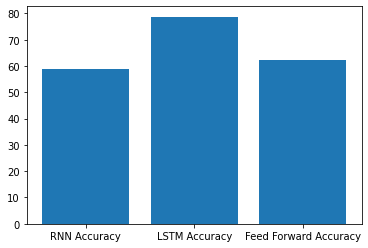

In [18]:
main = tkinter.Tk()
main.title("Crop Yield Prediction using RNN, Feedforward and LSTM Neural Network")
main.geometry("1000x650")

global filename
global rnn_acc,lstm_acc, ff_acc
global classifier
global X, Y, Y1
global rainfall_dataset
global crop_dataset
global le
scalerX = StandardScaler()

global weight_for_0
global weight_for_1

def upload():
    global filename
    global rainfall_dataset
    global crop_dataset
    global le
    
    filename = filedialog.askopenfilename(initialdir="dataset")
    rainfall_dataset=pd.read_csv(filename)
    file = filedialog.askopenfilename(initialdir="dataset")
    crop_dataset=pd.read_csv(file)
    
    crop_dataset.fillna(0, inplace = True)
    crop_dataset['Production'] = crop_dataset['Production'].astype(np.int64)
    print(crop_dataset.dtypes)
    print(crop_dataset.head())
    print(crop_dataset['Production'])
    text.delete('1.0', END)
    text.insert(END,filename+' Loaded\n\n')
    text.insert(END,str(crop_dataset.head()))

        

def preprocess():
    global weight_for_0
    global weight_for_1
    global crop_dataset
    global le
    global X, Y
    text.delete('1.0', END)
    le = LabelEncoder()
    crop_dataset['State_Name'] = pd.Series(le.fit_transform(crop_dataset['State_Name']))
    crop_dataset['District_Name'] = pd.Series(le.fit_transform(crop_dataset['District_Name']))
    crop_dataset['Season'] = pd.Series(le.fit_transform(crop_dataset['Season']))
    crop_dataset['Crop'] = pd.Series(le.fit_transform(crop_dataset['Crop']))
    crop_datasets = crop_dataset.values
    cols = crop_datasets.shape[1]-1
    print(crop_datasets.shape)
    X = crop_datasets[:,0:cols]
    Y = crop_datasets[:,cols]
    Y = Y.astype('uint8')
    avg = np.average(Y)
    #avg = avg / 60
    Y1 = []
    for i in range(len(Y)):
        if Y[i] >= avg:
            Y1.append(1)
        else:
            Y1.append(0)
    Y = np.asarray(Y1)
    Y = Y.astype('uint8')
    a,b = np.unique(Y, return_counts=True)
    print(str(a)+" "+str(b))
    Y = to_categorical(Y)
    Y = Y.astype('uint8')
    counts = np.bincount(Y[:, 0])
    weight_for_0 = 1.0 / counts[0]
    weight_for_1 = 1.0 / counts[1]
    print(X.shape)
    print(Y.shape)
    scalerX.fit(X)
    X = scalerX.transform(X)
    text.insert(END,str(X))

def runRNN():
    global rnn_acc
    global X, Y
    global classifier
    text.delete('1.0', END)
    global rnn_acc
    global weight_for_0
    global weight_for_1
    if os.path.exists('model/rnnmodel.json'):
        with open('model/rnnmodel.json', "r") as json_file:
            loaded_model_json = json_file.read()
            classifier = model_from_json(loaded_model_json)
        classifier.load_weights("model/rnnmodel_weights.h5")
        classifier.make_predict_function()   
        print(classifier.summary())
        f = open('model/rnnhistory.pckl', 'rb')
        data = pickle.load(f)
        f.close()
        accuracy = data[1] * 100
        rnn_acc = accuracy
        text.insert(END,'RNN Prediction Accuracy : '+str(accuracy)+"\n\n")
    else:
        class_weight = {0: weight_for_0, 1: weight_for_1}
        rnn = Sequential() #creating RNN model object
        rnn.add(SimpleRNN(256, input_dim=X.shape[1], activation='relu', kernel_initializer = "uniform")) #defining one layer with 256 filters to filter dataset
        rnn.add(SimpleRNN(128, activation='relu', kernel_initializer = "uniform"))#defining another layer to filter dataset with 128 layers
        rnn.add(Dense(Y.shape[1], activation='sigmoid',kernel_initializer = "uniform")) #after building model need to predict two classes such as normal or Dyslipidemia disease
        rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #while filtering and training dataset need to display accuracy 
        print(rnn.summary()) #display rnn details
        rnn_acc = rnn.fit(X, Y, epochs=100, batch_size=64,class_weight=class_weight) #start building RNN model
        values = rnn_acc.history #save each epoch accuracy and loss
        values = values['accuracy']
        acc = values[1] * 100
        rnn_acc = acc;
        f = open('model/rnnhistory.pckl', 'wb')
        pickle.dump(values, f)
        f.close()
        text.insert(END,'RNN Prediction Accuracy : '+str(acc)+"\n\n")
        classifier = rnn
        classifier.save_weights('model/rnnmodel_weights.h5')
        model_json = classifier.to_json()
        with open("model/rnnmodel.json", "w") as json_file:
            json_file.write(model_json)
values=0
def runLSTM():
    global lstm_acc
    global classifier
    global values
    text.delete('1.0',END)
    if os.path.exists('model/lstmmodel.json'):
        with open('model/lstmmodel.json', "r") as json_file:
            loaded_model_json = json_file.read()
            classifier= model_from_json(loaded_model_json)
        classifier.load_weights("model/lstmmodel_weights.h5")
        classifier.make_predict_function()   
        print(classifier.summary())
        f = open('model/lstmhistory.pckl', 'rb')
        data = pickle.load(f)
        f.close()
        accuracy = data[1] * 100
        lstm_acc = accuracy
        text.insert(END,'LSTM Prediction Accuracy : '+str(accuracy)+"\n\n")
    else:
        XX = np.reshape(X,(X.shape[0], X.shape[1], 1)) 
        print(XX.shape)
        model = Sequential() #creating LSTM model object
        model.add(LSTM(512,input_shape=(X.shape[1],1),activation="relu",return_sequences=True)) #defining LSTM layer in sequential object
        model.add(Dropout(0.5)) #removing irrelevant dataset features
        model.add(LSTM(256, activation='relu',return_sequences=True))#create another layer
        model.add(Dense(1, activation='sigmoid'))#predict two values as normal or Dyslipidemia disease
        model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])#calculate accuracy
        print(Y)
        #print(model.output_shape)
        lstm_acc = model.fit(XX, np.array(l), epochs=100, batch_size=64) #start training model
        values = lstm_acc.history
        
        values1 = values['accuracy']
        acc = values1[0] * 100
        lstm_acc = acc
        #f = open('model/lstmhistory.pckl', 'wb')
        #pickle.dump(values, f)
        #f.close()
        text.insert(END,'LSTM Prediction Accuracy : '+str(acc)+"\n\n")
        classifier = model
        classifier.save_weights('model/lstmmodel_weights.h5')
        model_json = classifier.to_json()
        with open("model/lstmmodel.json", "w") as json_file:
            json_file.write(model_json)
        

def runFF():
    global ff_acc
    global classifier
    text.delete('1.0',END)
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(model.summary())
    classifier=model
    lstm_acc = model.fit(X, Y, epochs=100, batch_size=64) #start training model
    values = lstm_acc.history
    values = values['accuracy']
    ff_acc = values[1] * 100
    text.insert(END,'Feed Forward Neural Network Prediction Accuracy : '+str(ff_acc)+"\n\n")
    

def predict():
    global classifier
    text.delete('1.0', END)
    file = filedialog.askopenfilename(initialdir="dataset")
    test = pd.read_csv(file)
    test['State_Name'] = pd.Series(le.fit_transform(test['State_Name']))
    test['District_Name'] = pd.Series(le.fit_transform(test['District_Name']))
    test['Season'] = pd.Series(le.fit_transform(test['Season']))
    test['Crop'] = pd.Series(le.fit_transform(test['Crop']))
    test = test.values
    cols = test.shape[1]
    test = test[:,0:cols]
    test = scalerX.fit_transform(test)
    #test = test.reshape((test.shape[0], test.shape[1], 1)) 
    print(test.shape)
    #test = test[:,0:test.shape[1]] 
    y_pred = classifier.predict(test)
    print(y_pred)
    for i in range(len(test)):
        predict = np.argmax(y_pred[i])
        print(str(predict))
        if predict == 0:
            text.insert(END,"X=%s, Predicted = %s" % (test[i], 'Predicted Crop Yield will be LESS')+"\n\n")
        else:
            text.insert(END,"X=%s, Predicted = %s" % (test[i], 'Predicted Crop Yield will be HIGH')+"\n\n")

def predict1():
    global classifier
    text.delete('1.0', END)
    file = filedialog.askopenfilename(initialdir="dataset")
    test = pd.read_csv(file)
    test['State_Name'] = pd.Series(le.fit_transform(test['State_Name']))
    test['District_Name'] = pd.Series(le.fit_transform(test['District_Name']))
    test['Season'] = pd.Series(le.fit_transform(test['Season']))
    test['Crop'] = pd.Series(le.fit_transform(test['Crop']))
    test = test.values
    cols = test.shape[1]
    test = test[:,0:cols]
    test = scalerX.fit_transform(test)
    test = test.reshape((test.shape[0], test.shape[1], 1)) 
    print(test.shape)
    #test = test[:,0:test.shape[1]] 
    y_pred = classifier.predict(test)
    print(y_pred)
    for i in range(len(test)):
        predict = np.argmax(y_pred[i])
        print(str(predict))
        if predict == 0:
            text.insert(END,"X=%s, Predicted = %s" % (test[i], 'Predicted Crop Yield will be LESS')+"\n\n")
        else:
            text.insert(END,"X=%s, Predicted = %s" % (test[i], 'Predicted Crop Yield will be HIGH')+"\n\n")
            
def predict2():
    global classifier
    text.delete('1.0', END)
    file = filedialog.askopenfilename(initialdir="dataset")
    test = pd.read_csv(file)
    test['State_Name'] = pd.Series(le.fit_transform(test['State_Name']))
    test['District_Name'] = pd.Series(le.fit_transform(test['District_Name']))
    test['Season'] = pd.Series(le.fit_transform(test['Season']))
    test['Crop'] = pd.Series(le.fit_transform(test['Crop']))
    test = test.values
    cols = test.shape[1]
    test = test[:,0:cols]
    test = scalerX.fit_transform(test)
    #test = test.reshape((test.shape[0], test.shape[1], 1)) 
    print(test.shape)
    #test = test[:,0:test.shape[1]] 
    y_pred = classifier.predict(test)
    print(y_pred)
    for i in range(len(test)):
        predict = np.argmax(y_pred[i])
        print(str(predict))
        if predict == 0:
            text.insert(END,"X=%s, Predicted = %s" % (test[i], 'Predicted Crop Yield will be LESS')+"\n\n")
        else:
            text.insert(END,"X=%s, Predicted = %s" % (test[i], 'Predicted Crop Yield will be HIGH')+"\n\n")
    
def graph():
    global rnn_acc,lstm_acc
    bars = ['RNN Accuracy','LSTM Accuracy','Feed Forward Accuracy']
    height = [rnn_acc,lstm_acc, ff_acc]
    y_pos = np.arange(len(bars))
    plt.bar(y_pos, height)
    plt.xticks(y_pos, bars)
    plt.show()
    

def topGraph():
    global rainfall_dataset
    global crop_dataset
    rainfall_dataset = pd.read_csv('dataset/district wise rainfall normal.csv')
        
    rainfall = rainfall_dataset.groupby(['STATE_UT_NAME'])['ANNUAL'].agg(['sum'])
    rainfall = rainfall.sort_values("sum", ascending=False).reset_index()
    rainfall = rainfall.loc[0:5]
    print(type(rainfall))
    rainfall = rainfall.values
    x1 = []
    y1 = []
    for i in range(len(rainfall)):
        x1.append(str(rainfall[i,0]))
        y1.append(rainfall[i,1])
    
    rice = pd.read_csv('dataset/Agriculture In India.csv')
    rice.fillna(0, inplace = True)
    rice['Production'] = rice['Production'].astype(np.int64)
    rice = rice.groupby(['State_Name','Crop'])['Production'].agg(['sum'])
    rice = rice.sort_values("sum", ascending=False).reset_index()
    x2 = []
    y2 = []
    rice = rice.values
    for i in range(len(rice)):
        if str(rice[i,1]) == 'Rice':
            x2.append(str(rice[i,0]))
            y2.append(rice[i,2])
            if len(x2) > 5:
                break;
    x3 = []
    y3 = []
    for i in range(len(rice)):
        if str(rice[i,1]) == 'Coconut':
            x3.append(str(rice[i,0]))
            y3.append(rice[i,2])
            if len(x3) > 5:
                break;
    x4 = []
    y4 = []
    for i in range(len(rice)):
        if str(rice[i,1]) == 'Sugarcane':
            x4.append(str(rice[i,0]))
            y4.append(rice[i,2])
            if len(x4) > 5:
                break;

    x5 = []
    y5 = []
    for i in range(len(rice)):
        x5.append(str(rice[i,0]))
        y5.append(rice[i,2])
        if len(x5) > 5:
            break;

    
    fig1=plt.figure()
    axes0=fig1.add_axes([0,0,1.2,0.2])
    axes0.plot(x5,y5)
    axes0.set_title('top 6 vs any crop yield')
    axes1=fig1.add_axes([0,0.35,1.2,0.2])
    axes1.plot(x4,y4)
    axes1.set_title('top 6 state vs sugar cane')
    axes2=fig1.add_axes([0,0.7,1.2,0.2])
    axes2.plot(x3,y3)
    axes2.set_title('top 6 vs cocount')
    axes3=fig1.add_axes([0,1.05,1.2,0.2])
    axes3.plot(x2,y2)
    axes3.set_title('top 6 vs rice')
    axes4=fig1.add_axes([0,1.4,1.2,0.2])
    axes4.plot(x1,y1)
    axes4.set_title('top 6 rain fall and crop yield')
    plt.show()        
    

    
   
font = ('times', 15, 'bold')
title = Label(main, text='Crop Yield Prediction using RNN, Feedforward and LSTM Neural Network', justify=LEFT)
title.config(bg='lavender blush', fg='DarkOrchid1')  
title.config(font=font)           
title.config(height=3, width=120)       
title.place(x=100,y=5)
title.pack()

font1 = ('times', 12, 'bold')
uploadButton = Button(main, text="Upload Agriculture Dataset", command=upload)
uploadButton.place(x=10,y=100)
uploadButton.config(font=font1)  

preprocessButton = Button(main, text="Preprocess Dataset", command=preprocess)
preprocessButton.place(x=300,y=100)
preprocessButton.config(font=font1)

rnnButton = Button(main, text="Run RNN Algorithm", command=runRNN)
rnnButton.place(x=480,y=100)
rnnButton.config(font=font1)

predictButton = Button(main, text="Predict Disease using Test Data2", command=predict2)
predictButton.place(x=550,y=150)
predictButton.config(font=font1)

lstmButton = Button(main, text="Run LSTM Algorithm", command=runLSTM)
lstmButton.place(x=670,y=100)
lstmButton.config(font=font1)

ffButton = Button(main, text="Run Feedforward Neural Network", command=runFF)
ffButton.place(x=10,y=150)
ffButton.config(font=font1)

graphButton = Button(main, text="Accuracy Comparison Graph", command=graph)
graphButton.place(x=300,y=150)
graphButton.config(font=font1)

predictButton = Button(main, text="Predict Disease using Test Data", command=predict)
predictButton.place(x=10,y=200)
predictButton.config(font=font1)

predictButton = Button(main, text="Predict Disease using Test Data1", command=predict1)
predictButton.place(x=300,y=200)
predictButton.config(font=font1)

topButton = Button(main, text="Top 6 Crop Yield Graph", command=topGraph)
topButton.place(x=600,y=200)
topButton.config(font=font1)

font1 = ('times', 12, 'bold')
text=Text(main,height=20,width=160)
scroll=Scrollbar(text)
text.configure(yscrollcommand=scroll.set)
text.place(x=10,y=250)
text.config(font=font1) 

main.config(bg='light coral')
main.mainloop()


In [17]:
from tkinter import *
import tkinter
from tkinter import filedialog
import numpy as np
from tkinter.filedialog import askopenfilename
import pandas as pd 
from tkinter import simpledialog
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout, Flatten,LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras.layers
from tensorflow.keras.models import model_from_json
import pickle
from sklearn.preprocessing import StandardScaler

In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [4]:
from platform import python_version
print(python_version())

3.7.10


In [10]:
f=h5py.File("model/rnnmodel_weights.h5","r")
f.keys()

<KeysViewHDF5 ['dense_1', 'dense_2', 'dense_3']>

In [7]:
import h5py

In [8]:
from h5py import h5

In [17]:
f.get('dense_3')

<HDF5 group "/dense_3" (1 members)>

In [19]:
f=h5py.File("model/lstmmodel_weights.h5",'r')

In [20]:
f.keys()

<KeysViewHDF5 ['dense_4', 'dense_5', 'dropout_1', 'lstm_1']>

In [21]:
f.get("dense_4")

<HDF5 group "/dense_4" (1 members)>

In [22]:
import pickle
pickle_in=open("model/rnnhistory.pckl","rb")
example_dict=pickle.load(pickle_in)
print(example_dict)

[0.5531856, 0.58845305]


In [9]:
print(Y.shape[1])

2


In [23]:
Y

array([[0, 1],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [1, 0]], dtype=uint8)

In [28]:
np.array(Y)

array([[0, 1],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [1, 0]], dtype=uint8)

In [43]:
Y

array([[0, 1],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [1, 0]], dtype=uint8)

In [45]:
l=[]
for i in Y:
    l.append(i[0])

In [47]:
np.array(l)

array([0, 1, 1, ..., 0, 0, 1], dtype=uint8)

In [56]:
print(values)

[0.5472614765167236]


In [1]:
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg, 
NavigationToolbar2Tk)

In [5]:
from matplotlib.figure import Figure

In [7]:
fig=Figure(figsize=(5,5))
plot1=fig.add_subplot(111)

In [24]:
import seaborn as sns

<AxesSubplot:>

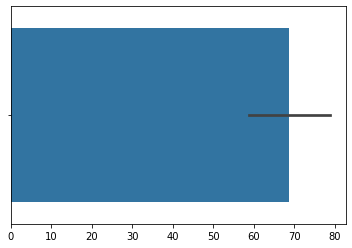

In [26]:
sns.barplot(x=[rnn_acc,lstm_acc])

In [1]:
import tensorflow

In [2]:
from tensorflow.keras.layers import LSTM

In [8]:
from tensorflow.keras.layers import SimpleRNN

In [6]:
from tensorflow.keras.layers import LSTM